# Regresión Logística Bayesiana

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/c/cb/Exam_pass_logistic_curve.svg" width="400px" height="400px" />

> Ya que conocemos la idea detrás de los métodos Montecarlo y como muestrear distribuciones, podemos ver una aplicación de estos conceptos.

> Uno de los modelos más usados para clasificación es la **regresión logística**. Con ella, podemos analizar como un conjunto de variables explicativas afectan cierta variable objetivo binaria. La distribución posterior sobre los pesos nos da una estimación de la influencia de cada variable explicativa particular en la probabilidad de que la variable objetivo sea uno.

> En esta clase nos apalancaremos del marco de trabajo en programación probabilística que ofrece la librería [pymc](https://www.pymc.io/welcome.html) para ver estas ideas.

> **Objetivos:**
> - Repasar la regresión logística.
> - Instalar pymc.
> - Modelar las distribuciones posteriores de parámetros en la regresión logística usando técnicas de muestreo.

> **Referencias:**
> - Bayesian Methods for Machine Learning course, HSE University, Coursera.

<p style="text-align:right;"> Imagen recuperada de: https://upload.wikimedia.org/wikipedia/commons/b/bf/Simple_random_sampling.PNG.</p>

___

## 0. Repaso regresión logística

Similar a la regresión lineal para análisis de regresión, tenemos a la contraparte logística para el análisis de clasificación.

En este caso, no se modela la variable objetivo binaria $y \in \{0, 1\}$ como una combinación lineal de predictores, sino 

$$
    p(y_i = 1 | w, x_i) = \sigma(w_1 x_i^{(1)} + w_2 x_i^{(2)} + \dots + w_d x_i^{(d)}) = \sigma(x_i^T w),
$$

donde $\sigma(z)=\frac{1}{1 + \exp\{-z\}}$.

Dado que $y_i \in \{0, 1\}$, podemos expresar:

$$
    p(y_i| w, x_i) = \sigma(x_i^T w)^{y_i} (1 - \sigma(x_i^T w))^{1 - y_i}.
$$

Entonces, sabemos que la función de verosimilitud es:

$$
\mathcal{L} (w) = p(y | w, X) = \prod_{i=1}^{N} p(y_i| w, x_i) = \prod_{i=1}^{N}\sigma(x_i^T w)^{y_i} (1 - \sigma(x_i^T w))^{1 - y_i}.
$$

Observaciones:

1. El estimador de máxima verosimilitud
   
   $$
   \hat{w}_{MLE} = \arg \max_{w} \mathcal{L}(w)
   $$
   
   no tiene una solución analítica en general.

2. La previa normal en los parámetros
   
   $$
   p(w) = \mathcal{N}(w | 0, \alpha I)
   $$
   
   ya no es previa conjugada para esta verosimilitud, como lo era para la regresion lineal. En efecto, es bastante complejo hallar una previa conjugada analítica para esta verosimilitud.

Dado que hallar la posterior

$$
p(w | y, X) = \frac{p(y | w, X) p(w)}{p(y | X)}
$$

de manera analítica no es un problema tratable, y dado que conocemos la distribución no normalizada

$$
p(y | w, X) p(w),
$$

podemos muestrear.

## 1. Instalación de pymc

Instalamos usando pip:

```
pip install pymc
```

De la [documentación](https://www.pymc.io/welcome.html):

PyMC is a probabilistic programming library for Python that allows users to build Bayesian models with a simple Python API and fit them using Markov chain Monte Carlo (MCMC) methods.

## 2. Modelamos usando muestreo



Utilizaremos datos del [Adult dataset UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Adult)

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np
import pymc as pm

In [2]:
# Leemos datos
data = pd.read_csv(
    "adult.data",
    names=[
        "age", "workclass", "fnlwgt", "education", 
        "education-num", "marital-status", "occupation",
        "relationship", "race", "sex", "capital-gain",
        "capital-loss", "hours-per-week", "native-country",
        "income"
    ]
)

In [3]:
# Procesamos datos
data = data[[
    "age",
    "education-num",
    "sex",
    "hours-per-week",
    "income"
]]
data["sex"] = (data["sex"] == " Female") * 1
data["income"] = (data["income"] == " >50K") * 1

In [4]:
data.rename(
    columns={
        "education-num": "educ",
        "hours-per-week": "hours"
    }, inplace=True
)

In [5]:
data

,age,educ,sex,hours,income
0,39,13,0,40,0
1,50,13,0,13,0
2,38,9,0,40,0
3,53,7,0,40,0
4,28,13,1,40,0
...,...,...,...,...,...
32556,27,12,1,38,0
32557,40,9,0,40,1
32558,58,9,1,40,0
32559,22,9,0,20,0


### Modelo manual

In [6]:
import aesara.tensor as at

In [14]:
with pm.Model() as manual_logistic_model:
    # Declaramos las distribución previa de los parámetros
    mean = np.zeros(5)
    cov = 100 * np.eye(5)
    w = pm.MvNormal("w", mu=mean, cov=cov, shape=(5,))
    
    # Usando estas variables, transformamos en el vector de probabilidades p(y_i=1 | w, x_i)
    # usando el modelo de regresión logística.
    z = at.dot(
        # X
        np.concatenate((
            np.ones((len(data), 1)),
            data.drop(columns=["income"])
        ), axis=1),
        # w
        w
    )
    p_y_hat = pm.invlogit(z)
    

    # Finalmente, declaramos la variable objetivo como una variable de Bernoulli con probabilidad
    # de éxito igual a las probabilidades de arriba.
    b_rv = pm.Bernoulli("b_rv", p_y_hat, observed=data["income"])
    
    # Con esto, ya tenemos nuestro modelo. Podemos usar pm.find_MAP() para encontrar el MAP de w
    map_estimate = pm.find_MAP()
    print(map_estimate)


{'w': array([-7.97123188,  0.04559825,  0.355073  , -1.16116427,  0.03563084])}


Dado que usamos una matriz de covarianza muy amplia (magnitud 100), el estimador MAP debería coincidir aproximadamente con el estimador MLE.

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
model = LogisticRegression().fit(data.drop(columns=["income"]), data["income"])

In [17]:
model.intercept_

array([-7.97232672])

In [18]:
model.coef_

array([[ 0.0456033 ,  0.35506874, -1.15950334,  0.03564412]])

### Ahora, si lo que queremos es obtener las posteriores


In [19]:
with pm.Model() as manual_logistic_model:
    # Declaramos las distribución previa de los parámetros
    mean = np.zeros(5)
    cov = 10 * np.eye(5)
    w = pm.MvNormal("w", mu=mean, cov=cov, shape=(5,))
    
    # Usando estas variables, transformamos en el vector de probabilidades p(y_i=1 | w, x_i)
    # usando el modelo de regresión logística.
    z = at.dot(
        np.concatenate((
            np.ones((len(data), 1)),
            data.drop(columns=["income"])
        ), axis=1),
        w
    )
    p_y_hat = pm.invlogit(z)
    

    # Finalmente, declaramos la variable objetivo como una variable de Bernoulli con probabilidad
    # de éxito igual a las probabilidades de arriba.
    b_rv = pm.Bernoulli("b_rv", p_y_hat, observed=data["income"])
    
    # Con esto, ya tenemos nuestro modelo. Podemos usar pm.find_MAP() para encontrar el MAP de w
    idata = pm.sample(
        tune=1000,
        draws=400,
        step=pm.Metropolis(),
        chains=2,
        init='adapt_diag',
        cores=-1
    )

Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [w]


/home/esteban/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/home/esteban/anaconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 111 seconds.


In [20]:
import arviz as az

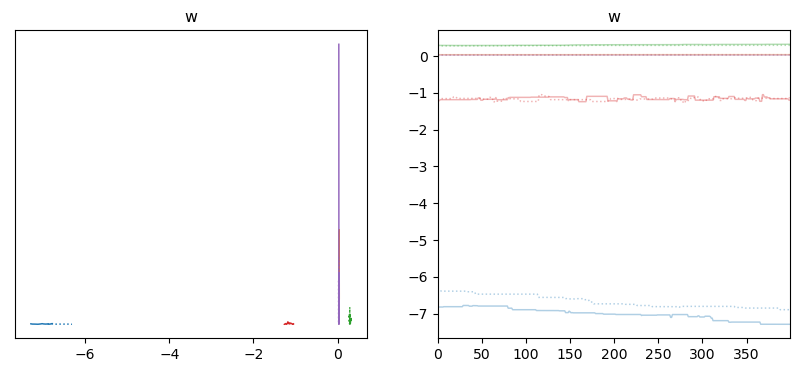

In [21]:
az.plot_trace(idata, figsize=(10, 4));

### Una forma más "elegante"

In [22]:
!pip install bambi

In [23]:
import bambi as bmb

In [24]:
model = bmb.Model("income ~ age + educ + sex + hours", data, family="bernoulli")
idata_ = model.fit(
    tune=1000,
    draws=400,
    chains=2,
    init='adapt_diag',
    cores=-1
)

Modeling the probability that income==1
Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, age, educ, sex, hours]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 82 seconds.


#### NUTS sampler

Al no especificar la forma en que se muestrea, pymc usa un método particular más avanzado que no vimos en clase.

El algoritmo de muestreo se llama NUTS (http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf), en la cual los parámetros se sintonizan automáticamente. Es un algoritmo avanzado, que converge más rápido y provee muestras menos correlacionadas que Metropolis-Hastings.

Sampling: [Intercept, age, educ, hours, sex]


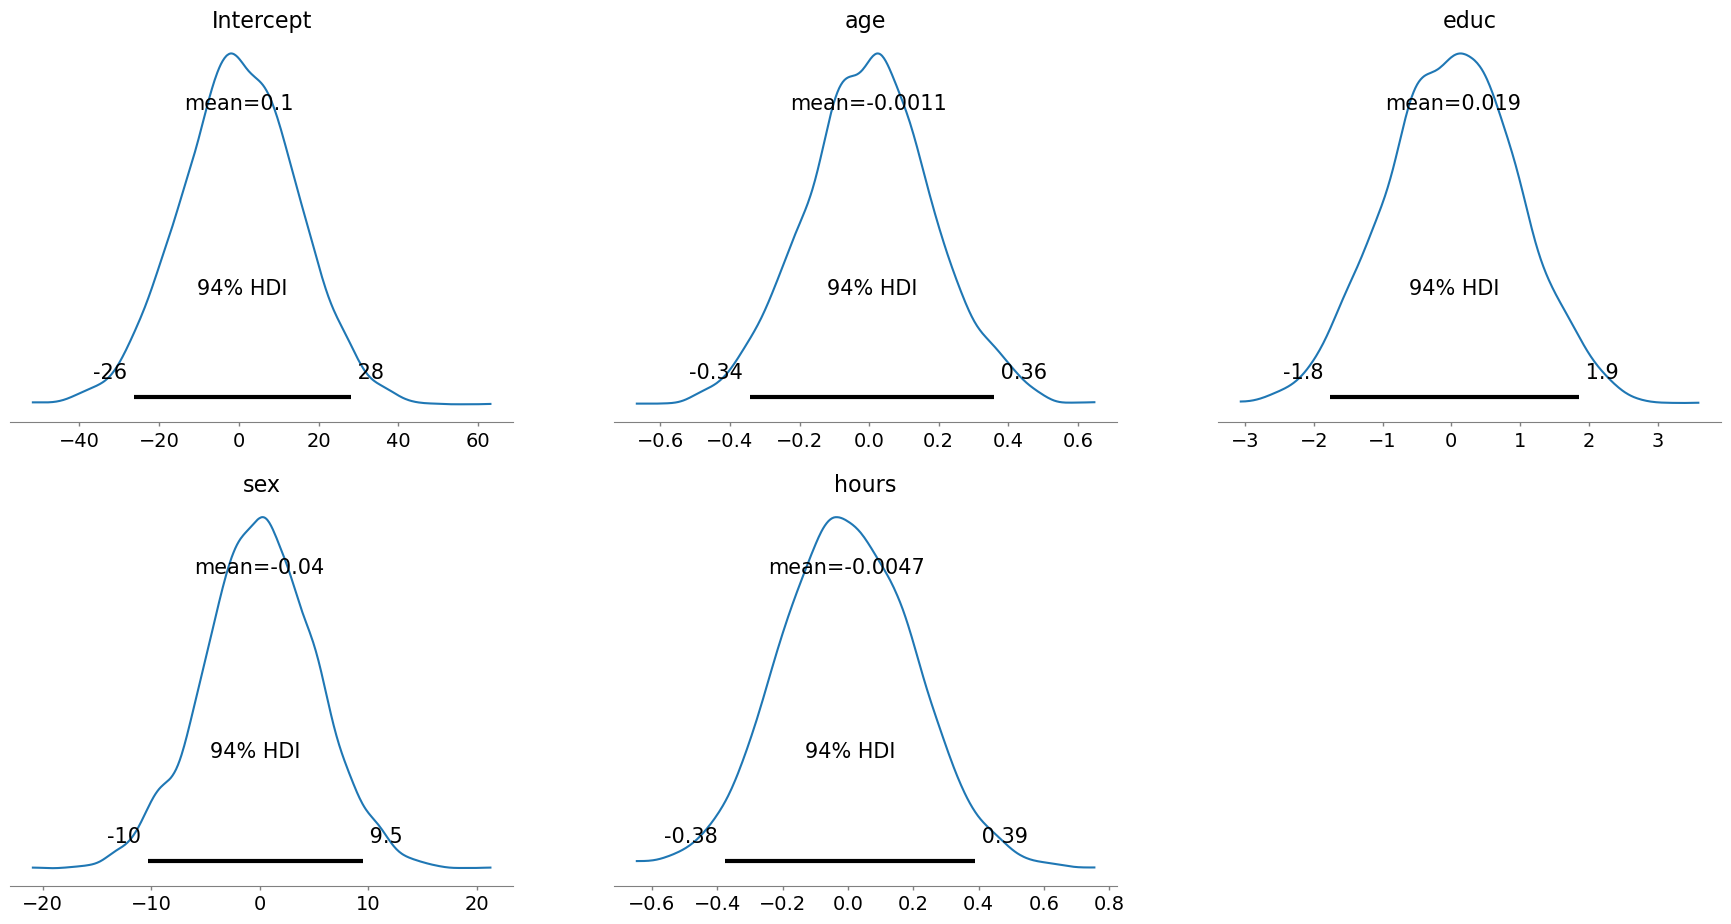

In [25]:
model.plot_priors();

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'educ'}>,
        <AxesSubplot:title={'center':'educ'}>],
       [<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'sex'}>],
       [<AxesSubplot:title={'center':'hours'}>,
        <AxesSubplot:title={'center':'hours'}>]], dtype=object)

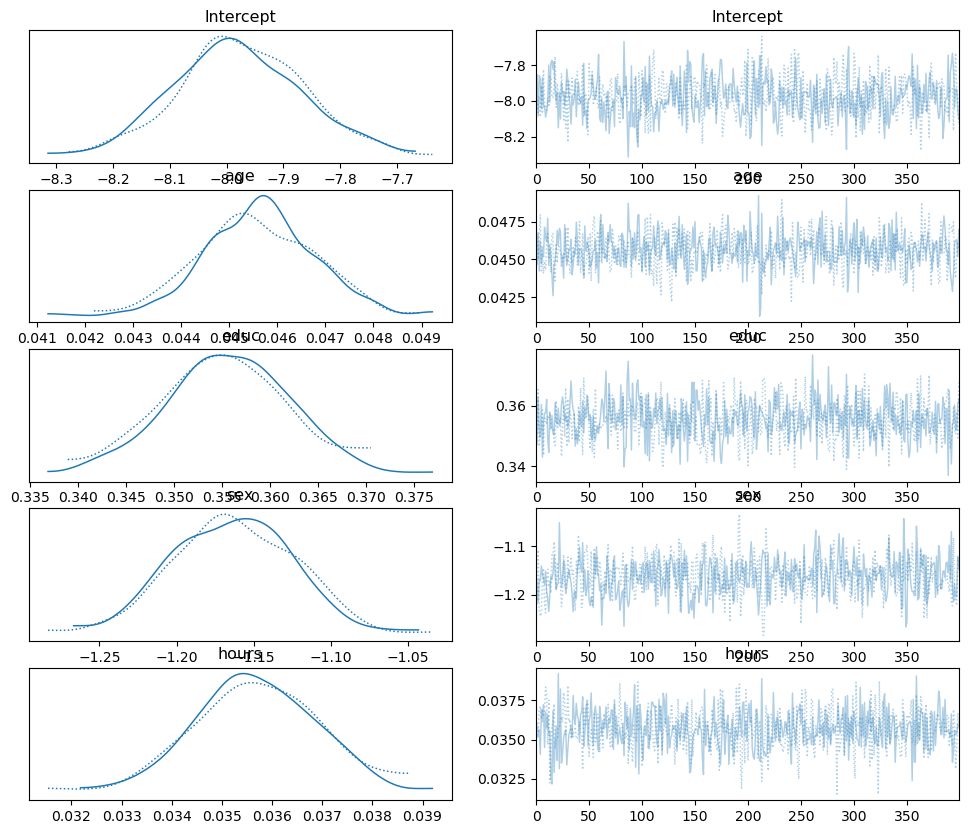

In [26]:
az.plot_trace(idata_)

In [27]:
az.summary(idata_)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-7.977,0.110,-8.189,-7.766,0.004,0.003,713.0,585.0,1.01
age,0.046,0.001,0.043,0.048,0.000,0.000,825.0,611.0,1.00
educ,0.355,0.007,0.343,0.368,0.000,0.000,814.0,624.0,1.00
sex,-1.163,0.039,-1.233,-1.091,0.002,0.001,661.0,521.0,1.01
hours,0.036,0.001,0.034,0.038,0.000,0.000,983.0,597.0,1.00


### Finalmente, con nuestras distribuciones posteriores estimadas, podemos realizar inferencia

¿Cómo cambia la probabilidad de tener ingresos altos con la edad y el sexo, para profesionales graduados que trabajan 40 horas a la semana?

In [30]:
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

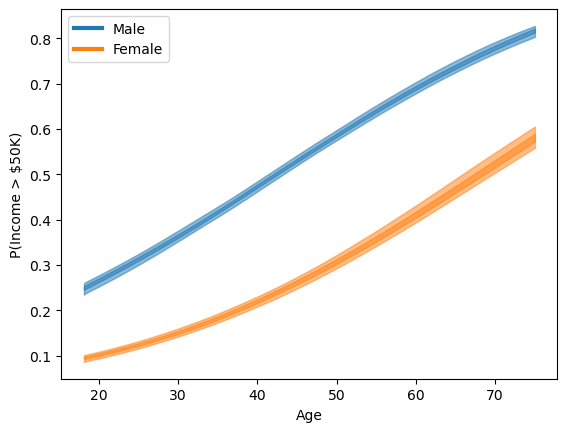

In [33]:
AGE = np.linspace(18, 75)
EDUC = 13
HOURS = 40

fig, ax = plt.subplots()
handles = []
i = 0

sex_dict = {1: "Female", 0: "Male"}

for sex in [0, 1]:
    color = f"C{i}"
    label = f"{sex_dict[sex]}"
    handles.append(mlines.Line2D([], [], color=color, label=label, lw=3))

    new_data = pd.DataFrame({
        "age": AGE,
        "educ": [EDUC] * len(AGE),
        "sex": [sex] * len(AGE),   
        "hours": [HOURS] * len(AGE)
    })
    new_idata = model.predict(idata_, data=new_data, inplace=False)
    mean = new_idata.posterior["income_mean"].values

    az.plot_hdi(AGE, mean, ax=ax, color=color)
    az.plot_hdi(AGE, mean, ax=ax, color=color, hdi_prob=0.5)
    i += 1

ax.set_xlabel("Age")
ax.set_ylabel("P(Income > $50K)")
ax.legend(handles=handles, loc="upper left");

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>